# Notebook evaluating metrics for particular node/edge configuration

In [1]:
# Import helper functions
# If new server on Descartes Labs, need to install rioxarray 
try: import rioxarray
except: 
    %pip install rioxarray
    
# Import helper functions
import helper_functions as hf
import netconf.netconf as nc

In [77]:
# Define variables
# Location variables
lat, lon, zoom = 33.893, 35.512, 14 # Map properties

# Building Footprints, damade assessments and interferogram file paths
buildingFile = "./data/beirutBuildingFootprints.geojson" # OSM data
assessmentFile = "./data/geopalData.csv" # GeoPal data
bourjData = "./data/bourjHammoud.csv"
manualData = "./data/manualDamageClasses.csv"
ifgPreFile = "./data/beirutPrePreExplosionIfg.tif" # SNAP output 1
ifgPostFile = "./data/beirutPrePostExplosionIfg.tif" # SNAP output 2
ifgBoth = False # If false, only uses prePost rather than difference between two

# A priori damage beliefs (green, yellow, red decisions)
decisions = {'GREEN': False, 'YELLOW': True, 'RED': True}
initBeliefs, confidence = [0.5,0.5], [0,0.9,1] # [noDmg, dmg], [Green,Yellow,Red]

# Edge creation
adjacent, geoNeighbours, ifgValues, neighbours = True, 4, True, 2

# Train/test split
testSplit, dmgThresh, stdTest, randomState = 0.3, 0.5, False, 42

# Classifications
targets = ['Undamaged', 'Damaged']

In [78]:
## Import Ground Data and combine
# Import footprints geojson
footprints = hf.import_OSM_fps(buildingFile)

# Import GeoPal assessments
assessments1 = hf.import_located_geopal_data(assessmentFile)

assessments2 = append_geopal_data(assessments1, bourjData, 'decision - القرار_w_2048411', True)

assessments = append_geopal_data(assessments2, manualData)

# Get joint geodataframe of building footprints with damage assessments
joint = hf.join_gdfs(footprints, assessments, column='decision')

# Display map of assessments upon which to draw Polygon for analysis
m1 = hf.create_map(lat, lon, zoom)
m1 = hf.plot_assessments(joint, m1)
m1, testPoly = hf.draw_polygon(joint, m1, stdTest)
m1

Map(center=[33.893, 35.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [75]:
# Import interferogram to dataframe
ifg, poly = hf.ifg_to_df(ifgPostFile, testPoly)

# If using both interferograms then subtract phase of second from first to get differecne
if ifgBoth: 
    ifgPre, _ = hf.ifg_to_df(ifgPreFile, testPoly)
    ifg = ifgPre-ifg

# Initialise beliefs for each pixel
initial = hf.init_beliefs(ifg, columns=['noDmg','dmg','ifg'], initBeliefs=initBeliefs)

# Split train/test set for located nodes
X_train, X_test, y_train, y_test = hf.train_test_split(joint, poly, column = 'decision')

# Create nodes
nodes = hf.create_nodes(initial, X_train)

# Assign prior beliefs from assessments
priors = hf.prior_beliefs(nodes, decisions, confidence, column = 'decision', beliefColumns = ['noDmg', 'dmg'])

# Create edges
edges = hf.create_edges(nodes, adjacent=adjacent, geo_neighbors=geoNeighbours, values=['ifg'] if ifgValues else False, neighbours=[neighbours])

In [76]:
# Run belief propagation
beliefs, _ = nc.netconf(edges,priors,verbose=True,limit=1e-7)

Nodes: 52522, Edges: 105044
It	max{del(B)}	del(label)

0	1.72314e+00		1162

1	1.17753e-01		541

2	4.04525e-01		398

3	4.22623e-02		328

4	9.81338e-02		249

5	1.83758e-02		192

6	2.45136e-02		145

7	6.41692e-03		113

8	6.28184e-03		96

9	2.04333e-03		61

10	1.64437e-03		38

11	6.19800e-04		14

12	4.37800e-04		19

13	1.82716e-04		18

14	1.18095e-04		16

15	5.29139e-05		14

16	3.21701e-05		5

17	1.51477e-05		0

18	8.82701e-06		0

19	4.30320e-06		0

20	2.43474e-06		0

21	1.21615e-06		0

22	6.74100e-07		0

23	3.42488e-07		0

24	1.87137e-07		0

25	9.62164e-08		0

Time elapsed: 137.34184980392456 seconds


              precision    recall  f1-score   support

   Undamaged       0.47      0.01      0.02       603
     Damaged       0.27      0.96      0.42       226

    accuracy                           0.27       829
   macro avg       0.37      0.49      0.22       829
weighted avg       0.41      0.27      0.13       829



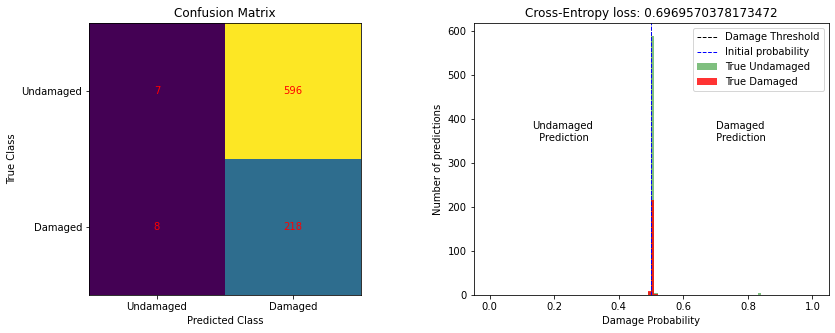

In [72]:
# Evaluation Metrics
# Get y_true vs y_pred for test set
y_true, y_pred = hf.get_labels(initial, X_test, beliefs, decisions, column='decision')

# Classification metrics
yp_clf, classes = hf.class_metrics(y_true, y_pred, targets, threshold=dmgThresh)

fig, axs = hf.create_subplots(1,2, figsize=[14,5])
# Confusion matrix
axs = hf.confusion_matrix(axs, y_true, yp_clf, classes)
  
# Cross entropy / Confidence metrics
axs = hf.cross_entropy_metrics(axs, y_true, y_pred, classes, dmgThresh, initBeliefs[1])

hf.show_plot()

In [73]:
# Save figure
hf.save_plot(fig, 'results/Beirut_extraData_adj{}{}_ifg{}{}_l-7'.format(str(adjacent),str(geoNeighbours),str(ifgValues),str(neighbours)))

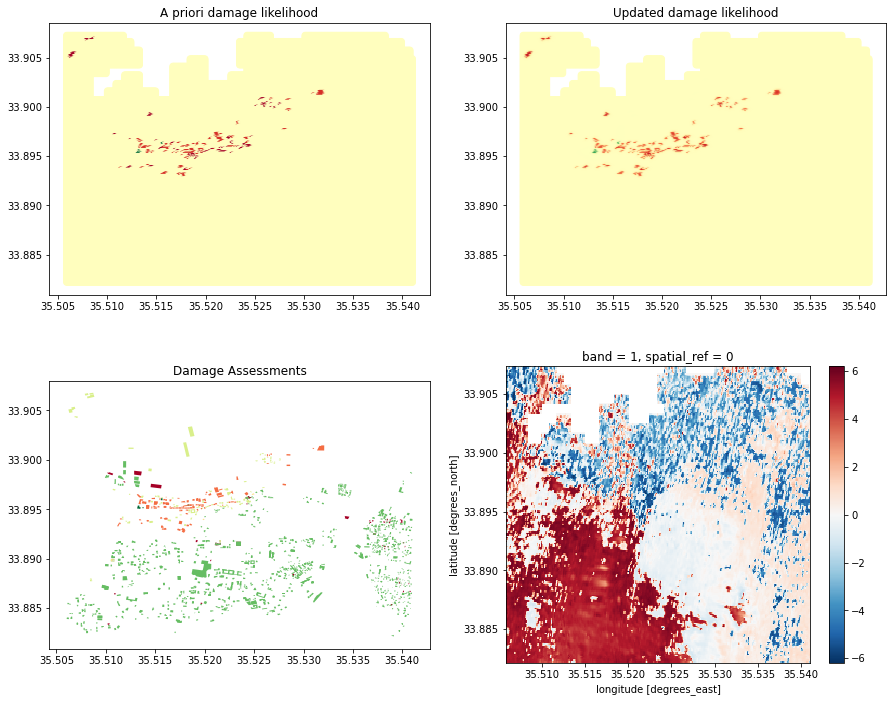

In [50]:
# Visualise spatial results
fig, axs = hf.create_subplots(2,2,figsize=[15,12])

prePlot = hf.belief_plot(nodes, axs[0,0], 'dmg', normalise=False)
postPlot = hf.belief_plot(nodes, axs[0,1], beliefs, normalise=True)
assessPlt = joint.loc[joint.within(poly)].plot(ax=axs[1,0], column='decision',cmap='RdYlGn_r')
ifgPlot = (hf.cropped_ifg(ifgPreFile,testPoly)-hf.cropped_ifg(ifgPostFile,testPoly)).plot(ax=axs[1,1])
prePlot.set_title('A priori damage likelihood'), postPlot.set_title('Updated damage likelihood'), assessPlt.set_title('Damage Assessments')

hf.show_plot()